In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

import sys
sys.path.insert(0, '..')
from mlconfound.stats import _binom_ci
from mlconfound.simulate import sinh_arcsinh


In [2]:
alpha=0.05

In [32]:
df=pd.read_csv("../data_out/ccc_partial_normal_cat_c=False_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=0.0_epsilon_yhat=0.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_normal'_random_seed=4242.csv").iloc[:, 1:]
df['y_ratio'] = df.yc_in_yhat / (df.c_to_y_ratio_in_yhat+1)
df['c_ratio'] = df.yc_in_yhat * df.c_to_y_ratio_in_yhat / (df.c_to_y_ratio_in_yhat+1)
df['noise_ratio'] = 1 - (df.y_ratio + df.c_ratio)

df

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,cov_y_c,num_perms,random_seed,y_ratio,c_ratio,noise_ratio
0,0.330,0.018327,0.018327,0.033823,50,0.0,0.0,0.0,1000,1019282514,0.00,0.00,1.0
1,0.525,0.007353,0.007353,0.018785,50,0.0,0.0,0.0,1000,1679872250,0.00,0.00,1.0
2,0.472,0.010726,0.010726,0.034227,50,0.0,0.0,0.0,1000,1837932928,0.00,0.00,1.0
3,0.093,0.059060,0.059060,0.034390,50,0.0,0.0,0.0,1000,1442006727,0.00,0.00,1.0
4,0.854,0.000768,0.000768,0.039799,50,0.0,0.0,0.0,1000,221822463,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.000,0.896217,0.896217,0.888008,1000,1.0,0.9,0.8,1000,301235933,0.45,0.45,0.1
39996,0.000,0.888342,0.888342,0.891314,1000,1.0,0.9,0.8,1000,1011369396,0.45,0.45,0.1
39997,0.000,0.884954,0.884954,0.890494,1000,1.0,0.9,0.8,1000,1369868937,0.45,0.45,0.1
39998,0.000,0.893212,0.893212,0.889125,1000,1.0,0.9,0.8,1000,1775743152,0.45,0.45,0.1


In [4]:
def positive_rate(data, alpha=alpha):
    return (data < alpha).sum() / len(data)

In [270]:
df_yc_in_yhat = df[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0

df_H1 = df[df.y_ratio != 0] 

df_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()
df_H0

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,cov_y_c,num_perms,random_seed,y_ratio,c_ratio,noise_ratio
0,0.330,0.018327,0.018327,0.033823,50,0.0,0.0,0.0,1000,1019282514,0.0,0.0,1.0
1,0.525,0.007353,0.007353,0.018785,50,0.0,0.0,0.0,1000,1679872250,0.0,0.0,1.0
2,0.472,0.010726,0.010726,0.034227,50,0.0,0.0,0.0,1000,1837932928,0.0,0.0,1.0
3,0.093,0.059060,0.059060,0.034390,50,0.0,0.0,0.0,1000,1442006727,0.0,0.0,1.0
4,0.854,0.000768,0.000768,0.039799,50,0.0,0.0,0.0,1000,221822463,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38395,0.375,0.613132,0.613132,0.986808,1000,0.0,0.9,0.8,1000,1040193158,0.9,0.0,0.1
38396,0.505,0.607980,0.607980,0.986165,1000,0.0,0.9,0.8,1000,364082909,0.9,0.0,0.1
38397,0.498,0.622202,0.622202,0.987334,1000,0.0,0.9,0.8,1000,1449959609,0.9,0.0,0.1
38398,0.595,0.647852,0.647852,0.986994,1000,0.0,0.9,0.8,1000,1597178978,0.9,0.0,0.1


In [6]:
print("False positive rate given H0:", positive_rate(df_H0.p))
print("Confidence intervals:", np.round(_binom_ci(len(df_H0.p)*0.05, len(df_H0.p)), 3))

False positive rate given H0: 0.0366875
Confidence intervals: [0.047 0.053]


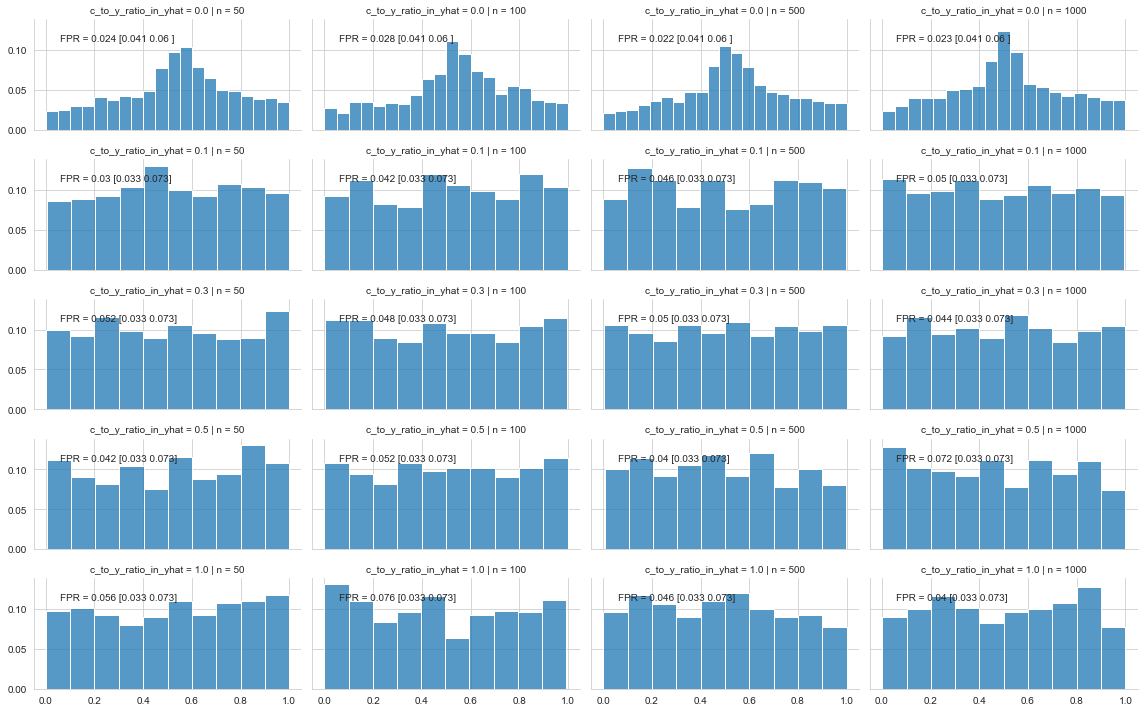

In [7]:
def annotate(data, **kws):
    FPR = positive_rate(data.p)
    ax = plt.gca()
    ax.text(0.1, .8, f"FPR = {np.round(FPR, 3)} {np.round(_binom_ci(len(data.p)*0.05, len(data.p)), 3)}", transform=ax.transAxes)

g=sns.FacetGrid(df_H0, col='n', row='c_to_y_ratio_in_yhat', height=2, aspect=2)
g.map(sns.histplot, "p", stat='probability')
g.map_dataframe(annotate)


In [8]:
df_H1 = df.loc[(df.c_to_y_ratio_in_yhat > 0) & (df.yc_in_yhat >0)]
df_H1

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,cov_y_c,num_perms,random_seed
2400,0.533,0.008597,0.008597,0.190566,50,0.1,0.3,0.0,1000,323672003
2401,0.962,0.000070,0.000070,0.299623,50,0.1,0.3,0.0,1000,1931310255
2402,0.422,0.014213,0.014213,0.061297,50,0.1,0.3,0.0,1000,983343362
2403,0.096,0.074110,0.074110,0.171384,50,0.1,0.3,0.0,1000,18978686
2404,0.782,0.001629,0.001629,0.064680,50,0.1,0.3,0.0,1000,1136612079
...,...,...,...,...,...,...,...,...,...,...
39995,0.000,0.896217,0.896217,0.888008,1000,1.0,0.9,0.8,1000,301235933
39996,0.000,0.888342,0.888342,0.891314,1000,1.0,0.9,0.8,1000,1011369396
39997,0.000,0.884954,0.884954,0.890494,1000,1.0,0.9,0.8,1000,1369868937
39998,0.000,0.893212,0.893212,0.889125,1000,1.0,0.9,0.8,1000,1775743152


0.01 0.01 0.01
0.01 0.01 0.01
0.01 0.01 0.01
0.01 0.01 0.01
0.01 0.01 0.01
0.16 0.04 0.04
0.14 0.05 0.05
0.13 0.06 0.06
0.11 0.07 0.07
0.09 0.09 0.09
0.69 0.17 0.17
0.67 0.2 0.2
0.6 0.26 0.26
0.54 0.32 0.32
0.43 0.43 0.43
0.99 0.24 0.24
0.98 0.29 0.29
0.93 0.4 0.4
0.86 0.49 0.49
0.69 0.69 0.69


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


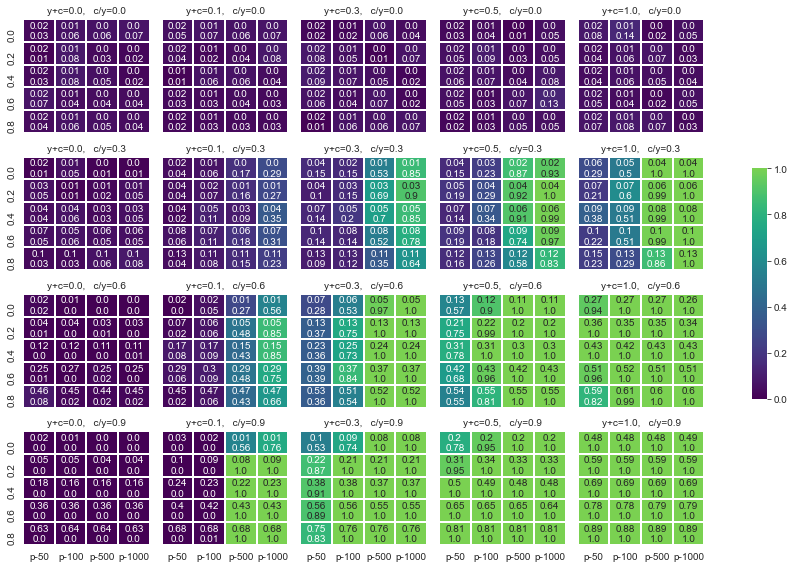

In [64]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)
    
    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)
    
    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values
    
    print(np.round(np.mean(r2_y_yhat.values), 2),
          np.round(np.mean(r2_yhat_c.values), 2),
          np.round(np.mean(r2_yhat_c.values), 2))
    
    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='cov_y_c', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   c/y={row_name}")

#plt.savefig('../data_out/fig/sim_ccc_normal_all_heatmap.pdf')

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


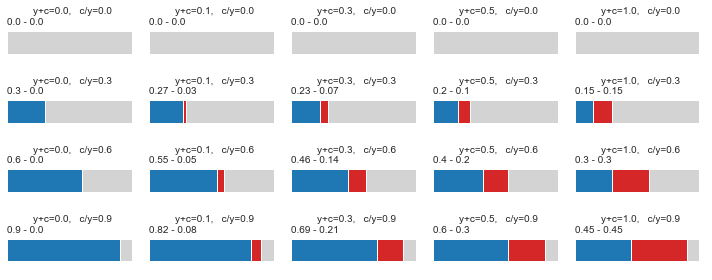

In [243]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    df_bar = pd.DataFrame({
        'y_ratio': [data['y_ratio'].mean()],
        'c_ratio': [data['c_ratio'].mean()],
        'noise_ratio': [data['noise_ratio'].mean()]
    })
    df_bar.plot(kind='barh', stacked=True, color=['tab:blue', 'tab:red', 'lightgray'],
                      legend=False, ax=plt.gca())
    plt.grid(False)
    plt.axis('off')
    plt.text(0,0.4, str(np.round(df_bar.y_ratio[0], 2)) + ' - ' + str(np.round(df_bar.c_ratio[0], 2)))

g=sns.FacetGrid(df, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=1, aspect=2)

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='cov_y_c', value='p')
g.set_titles("y+c={col_name},   c/y={row_name}")

plt.savefig('../data_out/fig/sim_weights_heatmap.pdf')

# non-normality

In [274]:
df_d100_e1=pd.read_csv("../data_out/ccc_partial_non-normal-all_cat_c=False_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=1.0_epsilon_yhat=1.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all'_random_seed=4242.csv").iloc[:, 1:]
df_d105_e3=pd.read_csv("../data_out/ccc_partial_non-normal-all2_cat_c=False_cat_yyhat=False_delta_yc=1.05_delta_yhat=1.05_epsilon_yc=3.0_epsilon_yhat=3.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all2'_random_seed=4242.csv").iloc[:, 1:]
df_d150_e5=pd.read_csv("../data_out/ccc_partial_non-normal-all3_cat_c=False_cat_yyhat=False_delta_yc=1.5_delta_yhat=1.5_epsilon_yc=5.0_epsilon_yhat=5.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all3'_random_seed=4242.csv").iloc[:, 1:]
df_d500_e10=pd.read_csv("../data_out/ccc_partial_non-normal-all4_cat_c=False_cat_yyhat=False_delta_yc=5.0_delta_yhat=5.0_epsilon_yc=10.0_epsilon_yhat=10.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all4'_random_seed=4242.csv").iloc[:, 1:]
df_d500_en10=pd.read_csv("../data_out/ccc_partial_non-normal-all5_cat_c=False_cat_yyhat=False_delta_yc=5.0_delta_yhat=5.0_epsilon_yc=-10.0_epsilon_yhat=-10.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all5'_random_seed=4242.csv").iloc[:, 1:]



df_yc_in_yhat = df_d100_e1[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d100_e1[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d100_e1_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d105_e3[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d105_e3[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d105_e3_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d150_e5[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d150_e5[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d150_e5_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d500_e10[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d500_e10[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d500_e10_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

df_yc_in_yhat = df_d500_en10[df.yc_in_yhat == 0]             # X contains information about neither y nor c: implies H0
df_c_to_y_ratio = df_d500_en10[df.c_to_y_ratio_in_yhat == 0]   # X contains information about c only trough y: implies H0
df_d500_en10_H0 = pd.concat((df_yc_in_yhat, df_c_to_y_ratio)).drop_duplicates()

#################################################################################

df_d100_e1['c_ratio'] = df_d100_e1.yc_in_yhat / (df_d100_e1.c_to_y_ratio_in_yhat+1)
df_d100_e1_H1 = df_d100_e1[df_d100_e1.c_ratio != 0] 

df_d105_e3['c_ratio'] = df_d105_e3.yc_in_yhat / (df_d105_e3.c_to_y_ratio_in_yhat+1)
df_d105_e3_H1 = df_d105_e3[df_d105_e3.c_ratio != 0] 

df_d150_e5['c_ratio'] = df_d150_e5.yc_in_yhat / (df_d100_e1.c_to_y_ratio_in_yhat+1)
df_d150_e5_H1 = df_d150_e5[df_d150_e5.c_ratio != 0] 

df_d500_e10['c_ratio'] = df_d500_e10.yc_in_yhat / (df_d500_e10.c_to_y_ratio_in_yhat+1)
df_d500_e10_H1 = df_d500_e10[df_d500_e10.c_ratio != 0] 



df_d500_e10_H1

,p,r2_y_c,r2_yhat_c,r2_y_yhat,n,c_to_y_ratio_in_yhat,yc_in_yhat,cov_y_c,num_perms,random_seed,c_ratio
2000,0.234,0.002637,0.001435,0.745829,50,0.0,0.3,0.0,1000,1077883300,0.30
2001,0.000,0.440270,0.105202,0.001563,50,0.0,0.3,0.0,1000,94267575,0.30
2002,0.010,0.072779,0.391289,0.172047,50,0.0,0.3,0.0,1000,237191205,0.30
2003,0.879,0.007295,0.000497,0.000417,50,0.0,0.3,0.0,1000,1261102006,0.30
2004,0.153,0.001297,0.003113,0.256454,50,0.0,0.3,0.0,1000,95286841,0.30
...,...,...,...,...,...,...,...,...,...,...,...
39995,0.575,0.333095,0.581533,0.908563,1000,1.0,0.9,0.8,1000,301235933,0.45
39996,0.000,0.292999,0.687075,0.739938,1000,1.0,0.9,0.8,1000,1011369396,0.45
39997,0.000,0.257280,0.796954,0.665060,1000,1.0,0.9,0.8,1000,1369868937,0.45
39998,0.000,0.571661,0.811419,0.872621,1000,1.0,0.9,0.8,1000,1775743152,0.45


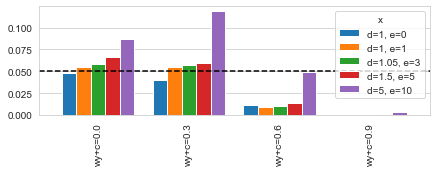

In [276]:
x=["d=1, e=0", "d=1, e=1", "d=1.05, e=3", "d=1.5, e=5", "d=5, e=10"]
fpr0=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0].p)
    ]
##############################
fpr1=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0.3].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0.3].p)
    ]
##############################
fpr2=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0.6].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0.6].p)
    ]
##############################
fpr3=[
    positive_rate(df_H0[df_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d100_e1_H0[df_d100_e1_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d105_e3_H0[df_d105_e3_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d150_e5_H0[df_d150_e5_H0.yc_in_yhat==0.9].p),
    positive_rate(df_d500_e10_H0[df_d500_e10_H0.yc_in_yhat==0.9].p)
    ]
df_bar=pd.DataFrame({
    'wy+c=0.0' : fpr0,
    'wy+c=0.3' : fpr1,
    'wy+c=0.6' : fpr2,
    'wy+c=0.9' : fpr3,
    'x' : x
})

ax=df_bar.set_index('x').transpose().plot(kind='bar', width=.8, figsize=(7,2))
ax.grid(axis='x')
plt.axhline(0.05, color='black', linestyle='--')
plt.savefig('../data_out/fig/sim_norm_violated.pdf')


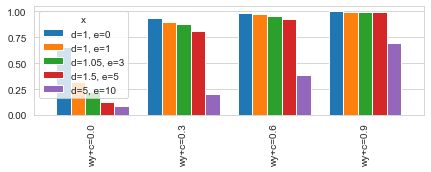

In [303]:
x=["d=1, e=0", "d=1, e=1", "d=1.05, e=3", "d=1.5, e=5", "d=5, e=10"]

n=1000

fpr0=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==0.1) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==0.1) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==0.1) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==0.1) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==0.1) & (df_d500_e10_H1.n == n)].p)
    ]
##############################
fpr1=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==0.3) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==0.3) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==0.3) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==0.3) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==0.3) & (df_d500_e10_H1.n == n)].p)
    ]
##############################
fpr2=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==0.5) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==0.5) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==0.5) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==0.5) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==0.5) & (df_d500_e10_H1.n == n)].p)
    ]
##############################
fpr3=[
    positive_rate(df_H1[(df_H1.c_to_y_ratio_in_yhat==1) & (df_H1.n == n)].p),
    positive_rate(df_d100_e1_H1[(df_d100_e1_H1.c_to_y_ratio_in_yhat==1) & (df_d100_e1_H1.n == n)].p),
    positive_rate(df_d105_e3_H1[(df_d105_e3_H1.c_to_y_ratio_in_yhat==1) & (df_d105_e3_H1.n == n)].p),
    positive_rate(df_d150_e5_H1[(df_d150_e5_H1.c_to_y_ratio_in_yhat==1) & (df_d150_e5_H1.n == n)].p),
    positive_rate(df_d500_e10_H1[(df_d500_e10_H1.c_to_y_ratio_in_yhat==1) & (df_d500_e10_H1.n == n)].p)
    ]
df_bar=pd.DataFrame({
    'wy+c=0.0' : fpr0,
    'wy+c=0.3' : fpr1,
    'wy+c=0.6' : fpr2,
    'wy+c=0.9' : fpr3,
    'x' : x
})

ax=df_bar.set_index('x').transpose().plot(kind='bar', width=.8, figsize=(7,2))
ax.grid(axis='x')
plt.savefig('../data_out/fig/sim_norm_violated_power_n1000.pdf')


In [288]:
df_H1[(df_H1.c_to_y_ratio_in_yhat==0.1) & (df_H1.n == n)].p

2400     0.533
2401     0.962
2402     0.422
2403     0.096
2404     0.782
         ...  
38495    0.216
38496    0.052
38497    0.311
38498    0.181
38499    0.189
Name: p, Length: 1500, dtype: float64

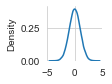

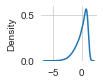

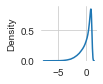

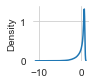

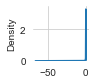

In [141]:
def std(x):
    return (x-np.mean(x)) / np.std(x)

x = np.random.normal(0,1,100000)

plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1, epsilon=0)))
plt.savefig('../data_out/fig/sim_dist1.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1, epsilon=1)))
plt.savefig('../data_out/fig/sim_dist2.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1.05, epsilon=3)))
plt.savefig('../data_out/fig/sim_dist3.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=1.5, epsilon=5)))
plt.savefig('../data_out/fig/sim_dist4.pdf')
plt.show()
plt.figure(figsize=(1,1))
plt.box(on=None)
sns.kdeplot(std(sinh_arcsinh(x, delta=5, epsilon=10)))
plt.savefig('../data_out/fig/sim_dist5.pdf')


In [195]:
skews=[]
kurts=[]

for i in range(1000):
    y = np.random.normal(0,1,100)
    # Skewness, with Heavy Tails
    yhat_t = sinh_arcsinh(y, delta=5, epsilon=10)
    kurts.append(kurtosis(yhat_t))
    skews.append(skew(yhat_t))

np.round((np.mean(kurts), np.mean(skews)), 2)

array([41.88, -6.03])

In [211]:
print("Confidence intervals global:", np.round(_binom_ci(len(df_H0.p)*0.05, len(df_H0.p)), 3))
print("Confidence intervals per simulation case:", np.round(_binom_ci(100*0.05, 100), 3))
print("Expected number of out-of-confidence H0 simulations:", 5*5*8*0.05)
print("With the upper confidence limit:", _binom_ci(5*5*8*0.05, 5*5*8)[1]*5*5*8)

Confidence intervals global: [0.047 0.053]
Confidence intervals per simulation case: [0.016 0.113]
Expected number of out-of-confidence H0 simulations: 10.0
With the upper confidence limit: 18.005507540270273


/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


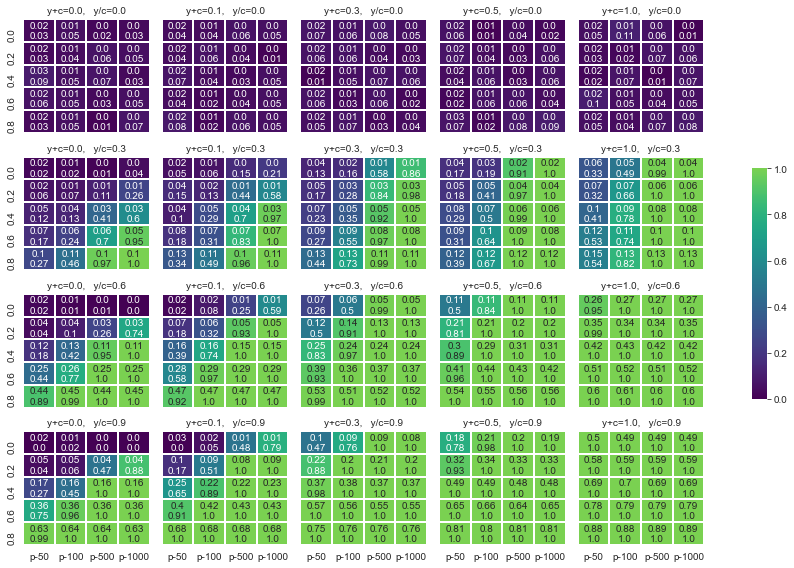

In [228]:
df_full=pd.read_csv("../data_out/ccb_full_normal_cat_c=True_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=0.0_epsilon_yhat=0.0_mode='full'_n_jobs=-1_out_file=None_out_prefix='ccb_full_normal'_random_seed=4242.csv").iloc[:, 1:]

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)
    
    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)
    
    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values
    
    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df_full, col='y_to_c_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='cov_y_c', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   y/c={row_name}")

plt.savefig('../data_out/fig/sim_ccb_full_normal_all_heatmap.pdf')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


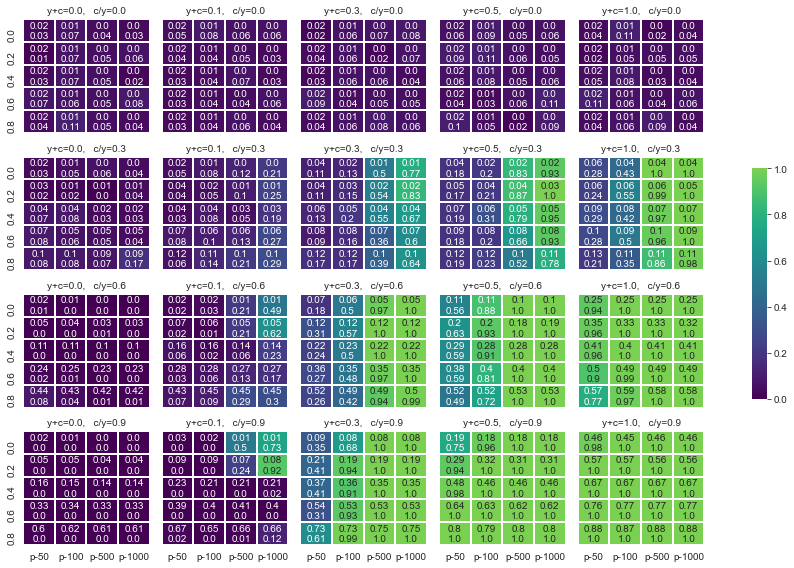

In [272]:
df_partial=pd.read_csv("../data_out/ccc_partial_non-normal-all_cat_c=False_cat_yyhat=False_delta_yc=1.0_delta_yhat=1.0_epsilon_yc=1.0_epsilon_yhat=1.0_mode='partial'_n_jobs=-1_out_file=None_out_prefix='ccc_partial_non-normal-all'_random_seed=4242.csv").iloc[:, 1:]
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def positive_rate_heatmap(data, col_a, col_b, value, **kws):
    
    r2_y_yhat = data.pivot_table(index=col_b, values=['r2_y_yhat'], columns=col_a, aggfunc=np.mean)
    r2_y_c = data.pivot_table(index=col_b, values=['r2_y_c'], columns=col_a, aggfunc=np.mean)
    r2_yhat_c = data.pivot_table(index=col_b, values=['r2_yhat_c'], columns=col_a, aggfunc=np.mean)
    
    pr = data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate)
    
    annot = np.round(r2_y_c, 2).astype(str).values + '\n' + np.round(pr, 2).astype(str).values
    
    sns.heatmap(data.pivot_table(index=col_b, values=[value], columns=col_a, aggfunc=positive_rate),
                linewidths=0.2,
                vmin=0, vmax=1,
                cmap=truncate_colormap(sns.color_palette("viridis", as_cmap=True), 0, 0.8),
                annot=annot, #True,
                fmt='',
                #annot=True,
                **kws)

g=sns.FacetGrid(df_partial, col='c_to_y_ratio_in_yhat', row='yc_in_yhat', height=2, aspect=1)
cbar_ax = g.fig.add_axes([1.05, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(positive_rate_heatmap, col_a='n', col_b='cov_y_c', value='p', cbar_ax=cbar_ax,)
g.set_titles("y+c={col_name},   c/y={row_name}")

plt.savefig('../data_out/fig/sim_ccb_partial_normal_all_heatmap.pdf')

In [267]:
res = []
w=0.3
for i in range(1000):
    x = np.random.normal(0,1,1000)
    y = np.random.normal(0,1,1000)
    res.append(np.corrcoef(x, w*x + (1-w)*y)[0,1]**2)
np.mean(res), np.std(res)

(0.1556101259964976, 0.020821765753161914)

In [304]:
0.1**2, 0.3**2, 0.5**2

(0.010000000000000002, 0.09, 0.25)